--- TRAINING XGBOOST PROFESSIONALE (1X2) ---
File caricato correttamente!
Dataset caricato: 6597 partite.
Periodo: dal 2017-08-11 al 2025-05-25

Feature utilizzate (9):
['Value_Ratio_vs_Opponent', 'Home_Value', 'Away_Value', 'Home_Lineup_Ratio', 'Away_Lineup_Ratio', 'Home_Attack_Form', 'Home_Defense_Form', 'Away_Attack_Form', 'Away_Defense_Form']

Split completato:
Train set: 5277 partite (Fino al 2023-12-20)
Test set:  1320 partite (Dal 2023-12-20)

--- INIZIO OTTIMIZZAZIONE IPERPARAMETRI ---
(Potrebbe richiedere qualche minuto...)
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ MIGLIORI PARAMETRI TROVATI:
{'subsample': 0.7, 'reg_lambda': 5, 'reg_alpha': 5, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
Miglior Log Loss (CV): 0.9758

--- VALUTAZIONE SU TEST SET (Dati mai visti) ---
Log Loss Finale: 0.9823 (Più basso è meglio, < 1.0 è buono)
Accuracy Pura:   52.27% (Non fidarti troppo di questa)

C:\Users\gianl\AppData\Local\Temp\ipykernel_31612\81747151.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')


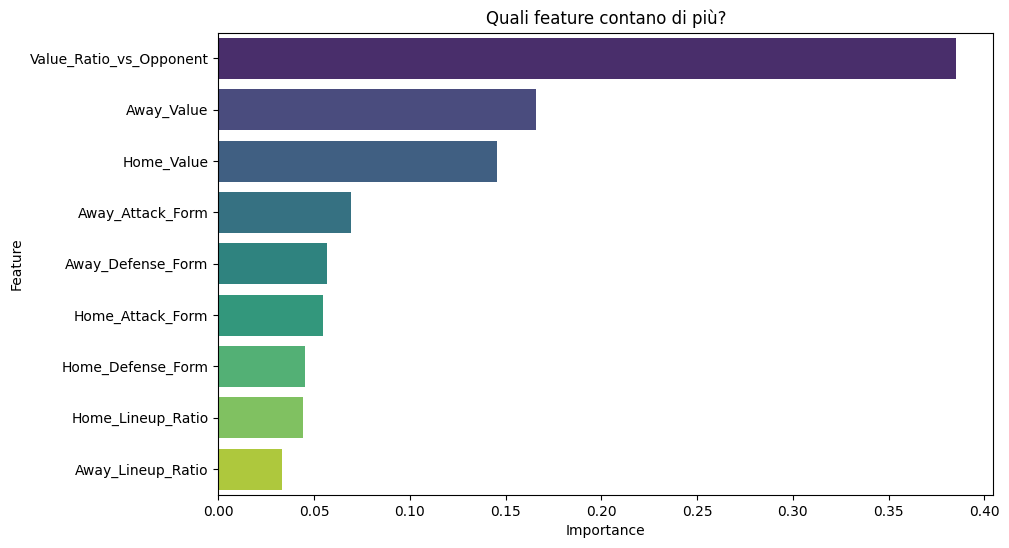


--- ESEMPIO ULTIME 5 PARTITE PREDETTE ---
           date   Home_Team        Away_Team    Prob_1    Prob_X    Prob_2  \
6592 2025-05-25  Villarreal          Sevilla  0.488387  0.283079  0.228534   
6593 2025-05-25   Liverpool   Crystal Palace  0.652501  0.190099  0.157400   
6594 2025-05-25     Venezia         Juventus  0.191333  0.256000  0.552668   
6595 2025-05-25    Atalanta            Parma  0.626150  0.219800  0.154050   
6596 2025-05-25      Fulham  Manchester City  0.201481  0.214208  0.584311   

      Target  
6592       0  
6593       1  
6594       2  
6595       2  
6596       2  


OSError: Cannot save file into a non-existent directory: 'data'

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Impostiamo il seed globale per la riproducibilità
SEED = 42

print("--- TRAINING XGBOOST PROFESSIONALE (1X2) ---")

# 1. CARICAMENTO E PREPARAZIONE
# ------------------------------------------------------------------------------

# I due punti ".." servono per uscire dalla cartella "train"
df = pd.read_csv('../data/dataset_train_final.csv')

print("File caricato correttamente!")
df['date'] = pd.to_datetime(df['date'])

# Ordiniamo per data (FONDAMENTALE per non barare usando il futuro)
df = df.sort_values('date').reset_index(drop=True)

print(f"Dataset caricato: {len(df)} partite.")
print(f"Periodo: dal {df['date'].min().date()} al {df['date'].max().date()}")

# 2. DEFINIZIONE FEATURES (X) E TARGET (y)
# ------------------------------------------------------------------------------
# Rimuoviamo colonne che non sono feature predittive (Date, Nomi, Quote)
# Le quote le togliamo dall'input, ma le salviamo per calcolare il ROI dopo!
features_to_drop = ['date', 'Home_Team', 'Away_Team', 'Target', 'Odds_1', 'Odds_X', 'Odds_2']

X = df.drop(columns=features_to_drop)
y = df['Target'] # 0=1, 1=X, 2=2

print(f"\nFeature utilizzate ({len(X.columns)}):")
print(list(X.columns))

# 3. SPLIT TRAIN / TEST (CRONOLOGICO)
# ------------------------------------------------------------------------------
# Usiamo l'80% più vecchio per il Train, il 20% più recente per il Test
split_index = int(len(df) * 0.80)

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]

X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

# Salviamo anche le info "umane" (squadre e quote) per analizzare il test set dopo
test_info = df.iloc[split_index:][['date', 'Home_Team', 'Away_Team', 'Odds_1', 'Odds_X', 'Odds_2', 'Target']].copy()

print(f"\nSplit completato:")
print(f"Train set: {len(X_train)} partite (Fino al {df.iloc[split_index]['date'].date()})")
print(f"Test set:  {len(X_test)} partite (Dal {df.iloc[split_index]['date'].date()})")

# 4. TUNING IPERPARAMETRI (CROSS VALIDATION)
# ------------------------------------------------------------------------------
print("\n--- INIZIO OTTIMIZZAZIONE IPERPARAMETRI ---")
print("(Potrebbe richiedere qualche minuto...)")

# Definiamo il modello base
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob', # Output: Probabilità per 3 classi
    num_class=3,                # 1, X, 2
    eval_metric='mlogloss',     # Minimizzare Log Loss
    random_state=SEED,
    n_jobs=-1                   # Usa tutti i core della CPU
)

# Griglia di parametri da testare (Space Search)
param_dist = {
    'n_estimators': [100, 200, 300, 500],        # Numero di alberi
    'learning_rate': [0.01, 0.05, 0.1, 0.2],     # Velocità di apprendimento
    'max_depth': [3, 4, 5, 6],                   # Profondità alberi (basso = meno overfitting)
    'min_child_weight': [1, 3, 5],               # Peso minimo per creare una foglia
    'gamma': [0, 0.1, 0.2],                      # Riduzione minima perdita
    'subsample': [0.7, 0.8, 0.9],                # % righe usate per ogni albero
    'colsample_bytree': [0.7, 0.8, 0.9],         # % colonne usate per ogni albero
    
    # --- REGOLARIZZAZIONE (La tua richiesta specifica) ---
    'reg_alpha': [0, 0.1, 1, 5],                 # L1 Regularization (Lasso) - Ottimo per feature inutili
    'reg_lambda': [0.1, 1, 5, 10]                # L2 Regularization (Ridge) - Stabilizza il modello
}

# Usiamo TimeSeriesSplit per la Cross Validation interna (CV)
# Divide il train set in 5 finestre temporali crescenti per testare i parametri
tscv = TimeSeriesSplit(n_splits=5)

# RandomizedSearch: Prova 50 combinazioni a caso invece di tutte (più veloce ed efficace)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                  # Numero di combinazioni da provare
    scoring='neg_log_loss',     # Metrica: Log Loss (Negativa perché Sklearn massimizza)
    cv=tscv,                    # Cross Validation temporale
    verbose=1,
    random_state=SEED,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# 5. RISULTATI DEL TRAINING
# ------------------------------------------------------------------------------
best_model = random_search.best_estimator_

print("\n✅ MIGLIORI PARAMETRI TROVATI:")
print(random_search.best_params_)
print(f"Miglior Log Loss (CV): {-random_search.best_score_:.4f}")

# 6. VALUTAZIONE SUL TEST SET (LA PROVA DEL FUOCO)
# ------------------------------------------------------------------------------
print("\n--- VALUTAZIONE SU TEST SET (Dati mai visti) ---")

# Predizioni (Probabilità)
preds_proba = best_model.predict_proba(X_test)
# Predizioni (Classe secca: 0, 1 o 2)
preds_class = best_model.predict(X_test)

# Calcolo Metriche
test_log_loss = log_loss(y_test, preds_proba)
test_accuracy = accuracy_score(y_test, preds_class)

print(f"Log Loss Finale: {test_log_loss:.4f} (Più basso è meglio, < 1.0 è buono)")
print(f"Accuracy Pura:   {test_accuracy:.2%} (Non fidarti troppo di questa)")

# Report dettagliato per classe
print("\nClassification Report:")
target_names = ['Home Win (1)', 'Draw (X)', 'Away Win (2)']
print(classification_report(y_test, preds_class, target_names=target_names))

# 7. FEATURE IMPORTANCE (COSA GUARDA IL MODELLO?)
# ------------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
# Prendi l'importanza delle feature
importances = best_model.feature_importances_
feature_names = X.columns
# Crea dataframe per plot
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title('Quali feature contano di più?')
plt.show()

# 8. ESEMPIO DI PREDIZIONE
# ------------------------------------------------------------------------------
# Uniamo le predizioni al dataframe "umano" per vedere i risultati
test_info['Prob_1'] = preds_proba[:, 0]
test_info['Prob_X'] = preds_proba[:, 1]
test_info['Prob_2'] = preds_proba[:, 2]
test_info['Pred_Class'] = preds_class

print("\n--- ESEMPIO ULTIME 5 PARTITE PREDETTE ---")
print(test_info[['date', 'Home_Team', 'Away_Team', 'Prob_1', 'Prob_X', 'Prob_2', 'Target']].tail())


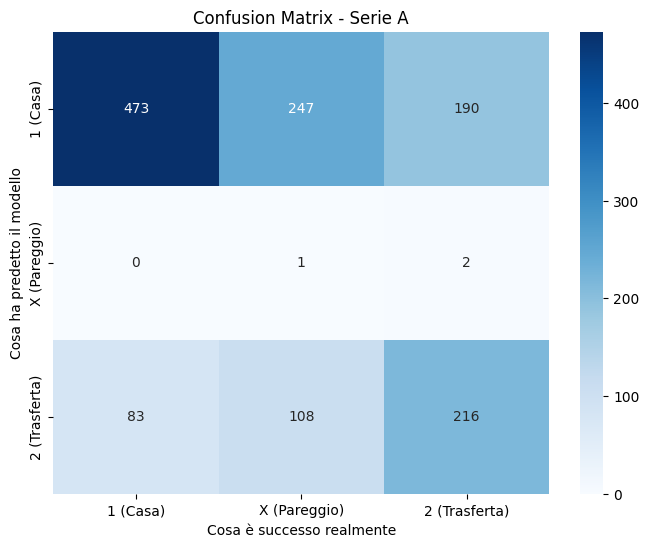


--- Report Dettagliato ---
               precision    recall  f1-score   support

     1 (Casa)       0.85      0.52      0.65       910
 X (Pareggio)       0.00      0.33      0.01         3
2 (Trasferta)       0.53      0.53      0.53       407

     accuracy                           0.52      1320
    macro avg       0.46      0.46      0.39      1320
 weighted avg       0.75      0.52      0.61      1320



In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Se y_pred sono probabilità (matrice con 3 colonne), usa argmax per prendere la classe più probabile

# 1. Calcola la matrice
# Assicurati che y_test e y_pred siano pronti
cm = confusion_matrix(preds_class, y_test)

# 2. Crea il grafico (Heatmap)
plt.figure(figsize=(8, 6))
# Le etichette dipendono da come hai codificato le classi. 
# Di solito nel calcio: 0=Casa(1), 1=Pareggio(X), 2=Trasferta(2)
# Se il tuo encoding è diverso, cambia l'ordine di questa lista
class_names = ['1 (Casa)', 'X (Pareggio)', '2 (Trasferta)']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.xlabel('Cosa è successo realmente')
plt.ylabel('Cosa ha predetto il modello')
plt.title('Confusion Matrix - Serie A')
plt.show()

# 3. Report testuale dettagliato (Precision e Recall per ogni segno)
print("\n--- Report Dettagliato ---")
print(classification_report(preds_class,y_test, target_names=class_names))